In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Mar  8 08:03:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    35W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/sl_videos/

bounded_padded_videos  new_train.txt  new_val.txt


In [ ]:
%cd /content/drive/MyDrive/sl_videos/
!ls 


/content/drive/MyDrive/sl_videos
bounded_padded_videos  new_train.txt  new_val.txt


In [ ]:
!nvcc --version
!pip install mxnet-cu110
#version was 1.7.0
!pip install --upgrade gluoncv
!pip install decord

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
     |████████████████████████████████| 325.4 MB 33 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 1.3 MB 4.1 MB/s 
     |████████████████████████████████| 13.6 MB 4.1 MB/s 


In [ ]:
from __future__ import division

import argparse, time, logging, os, sys, math

import numpy as np

import pandas
from decord import VideoReader

import mxnet as mx
import gluoncv 
from mxnet import gluon, nd, init, context
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

from gluoncv.data.transforms import video
from gluoncv.data import VideoClsCustom
import gluoncv.data 
from gluoncv.model_zoo import get_model
from gluoncv.utils import makedirs, LRSequential, LRScheduler, split_and_load, TrainingHistory

/usr/local/lib/python3.7/dist-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.0` and `torch==1.10.0+cu111` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


Took below code from 7. Fine-tuning SOTA video models on your own dataset
(but changed the transform function to the one from 6. Dive Deep into Training SlowFast mdoels on Kinetcis400)

TRAIN DATA GENRATOR


In [ ]:
#https://medium.com/apache-mxnet/gluoncv-0-6-embrace-video-understanding-49bc10ec1421

num_gpus = 1
ctx = [mx.gpu(i) for i in range(num_gpus)]

transform_train = transforms.Compose([
    # Fix the input video frames size as 256×340 and randomly sample the cropping width and height from
    # {256,224,192,168}. After that, resize the cropped regions to 224 × 224.
    video.VideoMultiScaleCrop(size=( 112,112), scale_ratios=[1.0, 0.9]), #WAS THIS  scale_ratios=[1.0, 0.875, 0.75, 0.66]
    # Randomly flip the video frames horizontally
    video.VideoRandomHorizontalFlip(),
    # Transpose the video frames from height*width*num_channels to num_channels*height*width
    # and map values from [0, 255] to [0,1]
    video.VideoToTensor(),
    # Normalize the video frames with mean and standard deviation calculated across all images
    #video.VideoNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

per_device_batch_size = 16#change batch size over here 
num_workers = 0 # these two lines are used if we were trying to use multiple gpus - so ignore
batch_size = per_device_batch_size * num_gpus

train_dataset = VideoClsCustom(root=os.path.expanduser('/content/drive/MyDrive/sl_videos/'),#bounded_videos/'),
                               setting=os.path.expanduser('/content/drive/MyDrive/sl_videos/new_train.txt'),  #CHANGE
                               train=True,
                               video_loader=True,
                               use_decord=True,
                               #video_ext = 'mp4',
                               new_step =2 ,
                               new_length=16,
                               #slowfast=True,
                               #slow_temporal_stride=8,
                              # fast_temporal_stride=2,
                              #  new_height = 224,
                               target_width= 112,
                               target_height= 112,
                               transform=transform_train
                               )
print('Load %d training samples.' % len(train_dataset))
train_data = gluon.data.DataLoader(train_dataset, batch_size=batch_size,
                                   shuffle=True, num_workers=num_workers)


Load 1987 training samples.


VAL DATA GENERATOR


In [ ]:
#https://medium.com/apache-mxnet/gluoncv-0-6-embrace-video-understanding-49bc10ec1421

num_gpus = 1
ctx = [mx.gpu(i) for i in range(num_gpus)]

transform_train = transforms.Compose([
    # Fix the input video frames size as 256×340 and randomly sample the cropping width and height from
    # {256,224,192,168}. After that, resize the cropped regions to 224 × 224.
   video.VideoMultiScaleCrop(size=( 112,112), scale_ratios=[1.0, 0.9]), #WAS THIS  scale_ratios=[1.0, 0.875, 0.75, 0.66]
    # Randomly flip the video frames horizontally
    video.VideoRandomHorizontalFlip(),
    # Transpose the video frames from height*width*num_channels to num_channels*height*width
    # and map values from [0, 255] to [0,1]
    video.VideoToTensor(),
    # Normalize the video frames with mean and standard deviation calculated across all images
   # video.VideoNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

per_device_batch_size = 16#change batch size over here 
num_workers = 0 # these two lines are used if we were trying to use multiple gpus - so ignore
batch_size = per_device_batch_size * num_gpus

val_dataset = VideoClsCustom(root=os.path.expanduser('/content/drive/MyDrive/sl_videos/'),#bounded_videos/'),
                               setting=os.path.expanduser('/content/drive/MyDrive/sl_videos/new_val.txt'),  #CHANGE
                               train=False,
                               video_loader=True,
                               use_decord=True,
                               #video_ext = 'mp4',
                                new_step =2 ,
                               new_length=16,
                               #slowfast=True,
                               ##slow_temporal_stride=8,
                               #ast_temporal_stride=2,
                              target_width= 112,
                               target_height= 112,
                               transform=transform_train
                               )


print('Load %d training samples.' % len(val_dataset))
val_data = gluon.data.DataLoader(val_dataset, batch_size=batch_size,
                                   shuffle=True, num_workers=num_workers)


Load 353 training samples.


will get erroe if you set pretrained = true. Instead you should set pretrained_base = true as we are changing the number of classes 

In [ ]:
#net = gluoncv.model_zoo.slowfast_4x16_resnet50_kinetics400(nclass=50, pretrained_base=True, num_segments=1, ctx=ctx)#check num_segments
#net = get_model(name='i3d_resnet50_v1_custom', nclass=2)
kinetics_model = get_model(name='c3d_kinetics400', nclass=400, pretrained=True)
net = get_model(name='c3d_kinetics400',nclass=50,pretrained=False,pretrained_base=True,feat_ext=False,partial_bn=True)

                   
                     
                    

source_params = kinetics_model.collect_params()
target_params = net.collect_params()
assert len(source_params.keys()) == len(target_params.keys())

pretrained_weights=[]
for layer_name in source_params.keys():
    pretrained_weights.append(source_params[layer_name].data())

for i, layer_name in enumerate(target_params.keys()):
    if i + 2 == len(source_params.keys()):
        # skip the last dense layer
        break
    target_params[layer_name].set_data(pretrained_weights[i])

net.collect_params().reset_ctx(ctx)

In [ ]:

net.summary
# or print(net) , both work 

<bound method Block.summary of C3D(
  (conv1): Conv3D(3 -> 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool1): MaxPool3D(size=(1, 2, 2), stride=(1, 2, 2), padding=(0, 0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCDHW)
  (conv2): Conv3D(64 -> 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool2): MaxPool3D(size=(2, 2, 2), stride=(2, 2, 2), padding=(0, 0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCDHW)
  (conv3a): Conv3D(128 -> 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3b): Conv3D(256 -> 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool3): MaxPool3D(size=(2, 2, 2), stride=(2, 2, 2), padding=(0, 0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCDHW)
  (conv4a): Conv3D(256 -> 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv4b): Conv3D(512 -> 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool

In [ ]:

net.collect_params().setattr('grad_req', 'null')
#net.avg.collect_params().setattr('grad_req', 'write')
#net.dp.collect_params().setattr('grad_req', 'write')
net.fc8.collect_params().setattr('grad_req', 'write')
#net.head.collect_params().setattr('grad_req', 'write')


In [ ]:
net.hybridize()
warmup_epoch = 30
total_epoch = 40
num_batches = len(train_data)
print(num_batches)
scheduler =mx.lr_scheduler.CosineScheduler(max_update=total_epoch, base_lr=1e-2, final_lr=1e-5, warmup_steps=warmup_epoch,  warmup_mode='linear',warmup_begin_lr=1e-2)

# lr_scheduler = LRSequential([
#     LRScheduler('linear', base_lr=0.1, target_lr=0.12,
#                 nepochs=warmup_epoch, iters_per_epoch=num_batches),
#     LRScheduler('cosine', base_lr=0.12, target_lr=0,
#                 nepochs=total_epoch - warmup_epoch,
#                 iters_per_epoch=num_batches,
#                 step_factor=lr_decay, power=2)
# ])
# Stochastic gradient descent
optimizer = 'Adam'#mxnet.optimizer.Adam(learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-08, )
# Set parameters
#optimizer_params = {'learning_rate':  0.005}  #,'wd': 0.0001, 'momentum': 0.9}
#optimizer_params['lr_scheduler'] = lr_scheduler





# Define our trainer for net
trainer = gluon.Trainer(net.collect_params(), optimizer, {})#the set of parameters to optimize
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()
train_metric = mx.metric.Accuracy()
val_metric = mx.metric.Accuracy()
train_history = TrainingHistory(['training-acc']) 

67


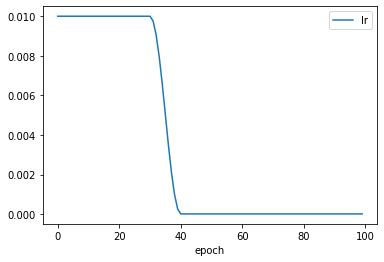

In [ ]:
import pandas as pd
df = pd.DataFrame(columns=['epoch','lr'])
for i in range(100):
  dictionary = {'epoch':i,'lr':scheduler(i)}
  df = df.append(dictionary,ignore_index=True)
  #print(optimizer.learning_rate)
df.plot(x = 'epoch', y = 'lr')

valid_acc = metric.Accuracy()
for data,label in valid_data:
    output = network(data)
    valid_acc.update(label,output)

[Epoch 0] train=0.066935 val=0.147309 loss=40.888991 lr=0.010000 time: 1348.099872
[Epoch 1] train=0.133870 val=0.167139 loss=40.595765 lr=0.010000 time: 167.535373
[Epoch 2] train=0.147458 val=0.198300 loss=43.464334 lr=0.010000 time: 166.381219
[Epoch 3] train=0.184701 val=0.195467 loss=43.063020 lr=0.010000 time: 166.077528
[Epoch 4] train=0.191746 val=0.192635 loss=43.455048 lr=0.010000 time: 166.064154
[Epoch 5] train=0.203825 val=0.203966 loss=45.194177 lr=0.010000 time: 165.705114
[Epoch 6] train=0.192753 val=0.209632 loss=48.388320 lr=0.010000 time: 166.845470
[Epoch 7] train=0.225969 val=0.201133 loss=46.054157 lr=0.010000 time: 166.351701
[Epoch 8] train=0.231002 val=0.243626 loss=49.529782 lr=0.010000 time: 165.926632
[Epoch 9] train=0.238551 val=0.237960 loss=45.200112 lr=0.010000 time: 165.297593
[Epoch 10] train=0.231002 val=0.260623 loss=49.703958 lr=0.010000 time: 165.671167
[Epoch 11] train=0.243583 val=0.237960 loss=49.327829 lr=0.010000 time: 166.802255
[Epoch 12] tr

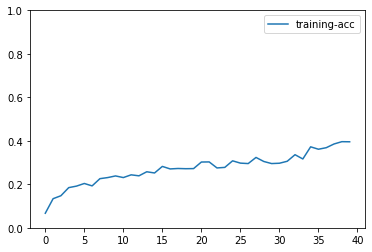

In [ ]:
epochs = total_epoch

for epoch in range(epochs):
    lr = scheduler(epoch)
    trainer.set_learning_rate(lr)
    tic = time.time()
    train_metric.reset()
    val_metric.reset()
    train_loss = 0

    # Loop through each batch of training data
    for i, batch in enumerate(train_data):
        # Extract data and label
        data = split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

        # AutoGrad
        with ag.record():
            output = []
            for _, X in enumerate(data):
                X = X.reshape((-1,) + X.shape[2:])
                pred = net(X)
                output.append(pred)
            loss = [loss_fn(yhat, y) for yhat, y in zip(output, label)]

        # Backpropagation
        for l in loss:
            l.backward()

        # Optimize
        trainer.step(batch_size)

        # Update metrics
        train_loss += sum([l.mean().asscalar() for l in loss])
        train_metric.update(label, output)

        #if i == 100:
         #   break

    name, acc = train_metric.get()

    #--------------------------------------------------------------------------
    for i, batch in enumerate(val_data):
        # Extract data and label
        data = split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

        
        val_output = []
        for _, X in enumerate(data):
            X = X.reshape((-1,) + X.shape[2:])
            pred = net(X)
            val_output.append(pred)
            
   
        val_metric.update(label, val_output)
    name_val, val_acc = val_metric.get()

    # Update history and print metrics
    train_history.update([acc])
    print('[Epoch %d] train=%f val=%f loss=%f lr=%f time: %f' %
        (epoch, acc, val_acc, train_loss / (i+1),trainer.learning_rate, time.time()-tic))
    
    if epoch%5==0:
      file_name = '/content/drive/MyDrive/c3d/c3d_kinetics400_fc_1/c3d_kinetics400_fc_1_epoch_'+str(epoch)+'.params'
      net.save_parameters(file_name)

# We can plot the metric scores with:
train_history.plot()


In [ ]:
print(net.slow_res3[0].conv1.weight.data())
print(net.fc.weight.data())

AttributeError: ignored